In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install fastai --upgrade
!pip install sentencepiece!=0.1.90,!=0.1.91

     |████████████████████████████████| 194kB 15.0MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 1.2MB 14.9MB/s 


In [2]:
!pip install fastai-ulmfit

### 2.1 (0.5 puntos) Cargue los datos del conjunto de entrenamiento y validación a un dataframe de pandas. Para cada conjunto muestre lo siguiente: la cantidad de reseñas por cada categoría de estrellas y la cantidad de palabras promedio por reseña. En la siguiente imagen una pequeña ayuda para realizar la carga de datos.


In [3]:
import json
import pandas as pd
from fastai_ulmfit.pretrained import *
from fastai.text.all import *

In [5]:
folder = "/content/drive/MyDrive/tarea2/dataset_es_dev.json"

In [6]:
# Se cargan los datos de entrenamiento.
df_train = pd.read_json('/content/drive/MyDrive/MDS/IA/dataset_es_train.json', lines=True)

In [7]:
df_train.head(5)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica estafa, no compreis!!",solo llega una unidad cuando te obligan a comprar dos,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo puedo decir que tras dos meses de espera.... sigo sin el producto y tuve que contactar con Amazon para reclamar su reembolso. Amazon un 10 . Se hace cargo del problema, pero yo e desembolsado mi dinero y en dos meses me lo devuelven Perdida de tiempo TOTAL. Sin palabras. Y Ustedes deciden",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [8]:
# Se cargan los datos de testeo.
df_test = pd.read_json('/content/drive/MyDrive/MDS/IA/dataset_es_test.json', lines=True)

In [9]:
# Se muestra la información.
df_test.head(3)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correos normal sin seguimiento y nunca me llego tota un desastre,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que el pedido no me llegó a tiempo y no cumplió los plazos de envío y era una cosa que necesitaba urgente. Para colmo me pongo en contacto con el vendedor y no da señales. No recomiendo nada,ESTAFA EN EL ENVÍO,es,toy


In [10]:
# Se crea un solo dataset que reune tanto el conjunto de entranamiento como de testeo  través de una concatenación.
df = pd.concat([df_train, df_test])

In [11]:
# Utilizando la biblioteca ULMFIT.
url = 'http://bit.ly/ulmfit-eswiki'
tok = tokenizer_from_pretrained(url)

In [12]:
# Investigando las columnas que tiene el dataset de train.
df_train.columns

Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')

In [13]:
# Creando un df que contenga solo el review.
df_lm = df_train[['review_body']]

In [14]:
# Mostrando el dataset recién creado.
df_lm

,review_body
0,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante
1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo"
2,"Te obligan a comprar dos unidades y te llega solo una y no hay forma de reclamar, una autentica estafa, no compreis!!"
3,"No entro en descalificar al vendedor, solo puedo decir que tras dos meses de espera.... sigo sin el producto y tuve que contactar con Amazon para reclamar su reembolso. Amazon un 10 . Se hace cargo del problema, pero yo e desembolsado mi dinero y en dos meses me lo devuelven Perdida de tiempo TOTAL. Sin palabras. Y Ustedes deciden"
4,Llega tarde y co la talla equivocada
...,...
199995,Mando funciona perfectamente y cumple con todas las funciones del original. Envio y embalaje perfecto. Una buena eleccion a un precio de risa.
199996,"Compré la batería con cierta reticencia, pero resultó muy fácil de instalar con los dos destornilladores que venían en el paquete y funciona a la perfección. Recomendable 100%"
199997,Buena calidad. Satisfecha con la compra.
199998,Perfecto para el cumple de mi hijo


### 2.2 (1.5 puntos) Construya un modelo de lenguaje usando los datos disponibles. Para ello tome como base el entrenamiento en español de Wikipedia hecho en la biblioteca ULMFIT (tal como lo hicimos en clase). Llegue a un valor de accuracy de al menos 0.30.

In [15]:
# Se crea el datablocks utilizando ULMFIT, variable independiente de text y un is_lm de true que indica si queremos usar
# textos para modelar el lenguaje u otra tarea y por último en el dataloader un batch size de 64.
dblocks = DataBlock(blocks=(TextBlock.from_df('review_body', tok=tok, is_lm=True)),
                    get_x=ColReader('text'))
dls = dblocks.dataloaders(df_lm, bs=64)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [16]:
# Se crea el primer modelo el cual es una función que depende del dataloader, la url que lleva a la base de entrenamiento
# de wikipedia, se le agrega un drop para evitar overfitting y to_fp16 para hacer el modelo más rápido.
learn = language_model_from_pretrained(dls, url=url, drop_mult=1).to_fp16()

SuggestedLRs(valley=tensor(0.0025))

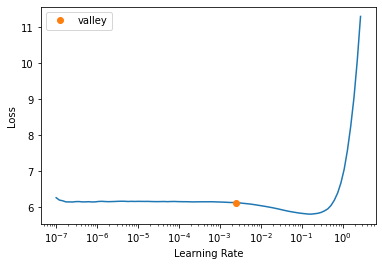

In [17]:
# Buscamos el lr óptimo.
learn.lr_find()

In [18]:
# Creamos un objeto lr
lr = 25e-3

In [19]:
# Un fit de prueba
learn.fit_one_cycle(1, lr, moms=(0.95,0.85,0.95))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.194475,3.920274,0.260592,50.414246,04:52


In [20]:
# Se descongelan las capas de a una.
# Se hace un fit de 4 ciclos
learn.unfreeze()
learn.fit_one_cycle(4, slice(lr/100,lr), moms=(0.95,0.85,0.95))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.966814,3.801209,0.275514,44.755249,05:02
1,3.858006,3.677259,0.288440,39.537891,05:02
2,3.701862,3.578662,0.297818,35.825581,05:06
3,3.562368,3.503042,0.306138,33.216351,05:03
4,3.501318,3.484468,0.308555,32.605061,05:02


In [21]:
# Se guarda el modelo encontrado.
learn.save('/content/drive/MyDrive/MDS/IA/first_trainer')

Path('/content/drive/MyDrive/MDS/IA/first_trainer.pth')

### 2.3 (1 punto) Use el modelo conseguido en el punto anterior para generar 3 reseñas de productos ficticias. ¿Que pasa si varía el parámetro temperature?

In [24]:
TEXT = "Ese notebook"
N_WORDS = 20
N_SENTENCES = 3
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [25]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁ese ▁note book ▁no ▁lo ▁he ▁recibido , me ▁han ▁devuelto ▁el ▁dinero . ▁xxbos ▁xxmaj ▁perfecta ▁para ▁estar ▁en ▁un ▁punto ▁de
▁xxbos ▁xxmaj ▁ese ▁note book ▁cubre ▁la ▁pantalla ▁xxbos ▁xxmaj ▁sin ▁instrucciones , ▁pero ▁no ▁me ▁gusta ▁la ▁forma ▁de ▁corte , ▁ya ▁que ▁no
▁xxbos ▁xxmaj ▁ese ▁note book ▁es ▁el ▁que ▁mejor ▁no ▁entiende ▁pero ▁lo ▁de ▁mejor ▁calidad ▁es ▁el ▁precio . ▁xxmaj ▁buena ▁compra . ▁xxbos


In [26]:
TEXT = "El galaxy Note 9"
N_WORDS = 20
N_SENTENCES = 3
preds = [learn.predict(TEXT, N_WORDS, temperature=0.50) 
         for _ in range(N_SENTENCES)]

In [27]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁el ▁galaxy ▁xxmaj ▁note ▁9 ▁es ▁compatible ▁con ▁el ▁xxmaj ▁apple ▁xxmaj ▁watch ▁y ▁el ▁cargador . ▁xxmaj ▁el ▁problema ▁es ▁que ▁no ▁tiene ▁ruedas
▁xxbos ▁xxmaj ▁el ▁galaxy ▁xxmaj ▁note ▁9 ▁no ▁se ▁ajusta ▁a ▁lo ▁que ▁buscaba . ▁xxmaj ▁la ▁funda ▁es ▁muy ▁endeble ▁y ▁se ▁rompe ▁con ▁mirarlo .
▁xxbos ▁xxmaj ▁el ▁galaxy ▁xxmaj ▁note ▁9 ▁tiene ▁un ▁tacto ▁muy ▁agradable , ▁pero ▁la ▁duración ▁de ▁la ▁batería ▁es ▁bastante ▁escasa . ▁xxmaj ▁no ▁lo ▁recomendaría


In [28]:
TEXT = "La televisión"
N_WORDS = 20
N_SENTENCES = 3
preds = [learn.predict(TEXT, N_WORDS, temperature=0.10) 
         for _ in range(N_SENTENCES)]

In [29]:
print("\n".join(preds))

▁xxbos ▁xxmaj ▁la ▁televisión ▁es ▁muy ▁bonita , ▁pero ▁la ▁calidad ▁de ▁imagen ▁es ▁pésima . ▁xxmaj ▁la ▁calidad ▁de ▁imagen ▁es ▁muy ▁mala
▁xxbos ▁xxmaj ▁la ▁televisión ▁es ▁muy ▁bonita , ▁pero ▁la ▁calidad ▁de ▁imagen ▁es ▁muy ▁mala , ▁no ▁se ▁puede ▁conectar ▁con ▁el ▁móvil
▁xxbos ▁xxmaj ▁la ▁televisión ▁es ▁muy ▁bonita , ▁pero ▁la ▁calidad ▁de ▁imagen ▁es ▁mala , ▁no ▁se ▁ve ▁nada , ▁pero ▁es ▁muy


Al variar el parámetro temperature, regula la "agresividad" del comentario.

### 2.4 (1.5 puntos) Use el modelo de lenguaje conseguido como punto de partida para realizar un modelo clasificador de texto para el problema de clasificar las reseñas (variable independiente) según su rating de estrellas (variable dependiente). Trate de llegar a una accuracy superior al 55%. ¿Podría explicar las razones de por qué se llega a un porcentaje de acierto tan bajo?

In [32]:
df_lm2 = df[['stars', 'review_body']]

In [33]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_df('review_body', vocab=dls.vocab),CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('stars'),
    splitter=RandomSplitter(0.1)).dataloaders(df_lm2, bs=128, seq_len=72)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [34]:
# Se crea el objeto que contiene el modelo guardado.
path = learn.save_lm('/content/drive/MyDrive/MDS/IA/firts_trainer')

In [35]:
# Se crea el modelo basado en el aprendisaje del modelo anterior.
learn2 = text_classifier_from_lm(dls_clas, path=path, metrics=[accuracy]).to_fp16()

SuggestedLRs(valley=tensor(0.0021))

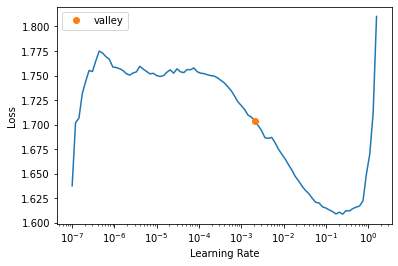

In [36]:
# Buscamos el LR óptimo.
learn2.lr_find()

In [37]:
# Como estamos utilizando un modelo pre entrenado, le podemos hacer directamente un fine tune.
learn2.fine_tune(10, 21e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.399764,1.309826,0.425366,02:07


epoch,train_loss,valid_loss,accuracy,time
0,1.150460,1.106540,0.512683,02:15
1,1.122031,1.091323,0.521854,02:15
2,1.102545,1.066522,0.527073,02:15
3,1.074377,1.043687,0.545366,02:15
4,1.040142,1.041715,0.542098,02:14
5,1.007324,1.040686,0.547073,02:14
6,0.975802,1.045155,0.545707,02:14
7,0.944189,1.053807,0.544683,02:14
8,0.907960,1.068662,0.544878,02:15
9,0.919771,1.073300,0.544829,02:16


El porcentaje de aciertos es bajo ya que el modelo comete muchos errores en su clasificación. Se puede deber principalmente a que el Modelo no es capaz de poder definir la categoría de los comentarios ya que no existen fronteras tan claras entre los distintos tipos de clases.

### 2.5 (1.5 puntos) ¿Qué pasa si disminuimos la cantidad de categorías a clasificar? (por ejemplo, agrupar niveles de rating de estrellas similares). Evalúe cómo varía el desempeño de la clasificación en base a este escenario.

In [38]:
# Se crea una nueva columna en donde se indica como positivo todos aquellos comentarios mayores o iguales a 4 y
# negativo todos los otros.
df["nps"] = df.apply(lambda x: "Positivo" if int(x["stars"]) >= 4 else "Negativo", axis=1)

In [39]:
# Se crea un nuevo df
df_lm3 = df[['nps', 'review_body']]

In [42]:
# Se crea el nuevo Datablock
dls_clas2 = DataBlock(
    blocks=(TextBlock.from_df('review_body', vocab=dls.vocab),CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('nps'),
    splitter=RandomSplitter(0.1)).dataloaders(df_lm3, bs=128, seq_len=72)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [43]:
# Se crea el modelo
learn3 = text_classifier_from_lm(dls_clas2, path=path, metrics=[accuracy]).to_fp16()

SuggestedLRs(valley=tensor(0.0014))

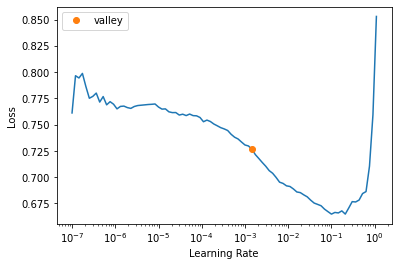

In [44]:
# Buscamos el LR óptimo.
learn3.lr_find()

In [45]:
# Le hacemos un fine tune.
learn2.fine_tune(10, 14e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.913107,1.068071,0.545415,02:11


epoch,train_loss,valid_loss,accuracy,time
0,0.902520,1.072211,0.546488,02:17
1,0.933732,1.068615,0.538098,02:17
2,0.943626,1.077296,0.541610,02:17
3,0.942928,1.079742,0.534049,02:18
4,0.898456,1.115751,0.537122,02:19
5,0.855507,1.116968,0.536195,02:18
6,0.822622,1.151743,0.532439,02:15
7,0.778568,1.181728,0.527707,02:17
8,0.747908,1.216867,0.525854,02:16
9,0.713471,1.231644,0.525024,02:16


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

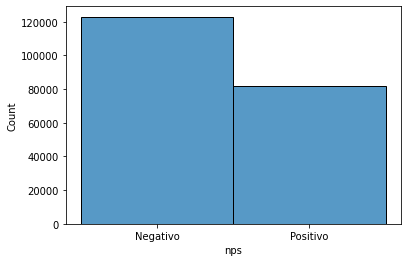

In [47]:
# Nos damos cuenta que la las clases no están desbalancedas.
sns.histplot(data=df, x="nps")
plt.show()

Al cambiar a menos clases el resultado varía de manera negativa bajando el accuracy en tres puntos